In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from PIL import Image
import soundfile as sf
import seaborn as sns
from scipy import fftpack
from scipy import signal
import sys
import keras
from keras.models import Sequential, Model
from tensorflow.python.keras import backend as k
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input, BatchNormalization, Reshape, UpSampling2D,LeakyReLU
from keras.utils. generic_utils import Progbar
sys.path.append("/Users/hiroki/PycharmProjects/frequency_analysis")
import frequency_analysis
import warnings
warnings.filterwarnings("ignore")

# Data read

In [2]:
#----------------------------------------------data read----------------------------------------------------------------------
files_a = glob.glob("/Users/hiroki/Desktop/shunt/A/*.wav")
files_v = glob.glob("/Users/hiroki/Desktop/shunt/V/*.wav")
files_a.sort()
files_v.sort()
fs = 44100
signal_artery = [sf.read(files_a[i])[0] for i in range(len(files_a))]
signal_vein = [sf.read(files_v[i])[0] for i in range(len(files_v))]

# #-------------------------------------signal cut out(30sec)---------------------------------------------------------------------------------
# start_time = 5 #sec
# end_time = 5 #sec  atenction abs(start)+abs(end)=30

# signal_artery_30sec = [signal_artery[i][round(round(len(signal_artery[i])/2)-fs*start_time) : round(round(len(signal_artery[i])/2)+fs*end_time)] for i in range(len(signal_artery))]
# signal_vein_30sec = [signal_vein[i][round(round(len(signal_vein[i])/2)-fs*start_time) : round(round(len(signal_vein[i])/2)+fs*end_time)] for i in range(len(signal_vein))]

# Signal cut out slide

In [3]:
data = signal_artery[65:]
window_length = 10 #sec
slide_length = 1 #sec
#------------------------------------------------------------------------------
signal_30sec = [data[i][round(round(len(data[i])/2)-fs*15) : round(round(len(data[i])/2)+fs*15)] for i in range(len(data))]
signal_cut = []
for sig in signal_30sec:
    sig_cut = [sig[i:i+fs*window_length] for i in range(0,len(sig)-window_length*fs,int(slide_length*fs))]
    signal_cut.append(sig_cut)
signal_cut = np.array(signal_cut)
signal_cut_slide = signal_cut.reshape(int(signal_cut.shape[0]*signal_cut.shape[1]), signal_cut.shape[2])

# Add noise

In [4]:
# time = 10 #sec
# amplitude_l = 0.05
# amplitude_h = 0.01

# f1_l, f2_l, f3_l = 120, 130, 140#Hz
# f1_h, f2_h, f3_h = 500, 700, 900#Hz

# sig = signal_cut_slide[0] #NO,65
# #----------------------------------------------------------------------------
# time_array = np.arange(fs*time)
# sin120 = amplitude_l * np.sin(2 * np.pi * f1_l * time_array / fs)
# sin130 = amplitude_l * np.sin(2 * np.pi * f2_l * time_array / fs)
# sin140 = amplitude_l * np.sin(2 * np.pi * f3_l * time_array / fs)

# sin500 = amplitude_h * np.sin(2 * np.pi * f1_h * time_array / fs)
# sin700 = amplitude_h * np.sin(2 * np.pi * f2_h * time_array / fs)
# sin900 = amplitude_h * np.sin(2 * np.pi * f3_h * time_array / fs)

# noise_low = sin120 + sin130 + sin140
# noise_high = sin500 + sin700 + sin900

# noise_signal_l = sig + noise_low
# noise_signal_h = sig + noise_high

In [19]:
time = 10 #sec
amplitude = 30

high_h, high_l = 900, 500 #Hz
low_h, low_l = 140, 120

bandpass = frequency_analysis.band_pass
sig = signal_cut_slide[0] #NO,65
#----------------------------------------------------------------------------------------------------
time_array =np.linspace(0, time, fs*time)
noise = amplitude * np.random.rand(fs * time)
noise_high = bandpass(noise, fs, high_l, high_h, high_l-150, high_h+150, 10)
noise_low = bandpass(noise, fs, low_l, low_h, low_l-50, low_h+50, 30)

noise_signal_l = sig + noise_low
noise_signal_h = sig + noise_high

#-------------------------------array to wav file----------------------------------------------------------
from scipy.io.wavfile import write
write("/Users/hiroki/Desktop/test.wav",fs,noise_signal_h)

# STFT

In [4]:
#------------------------------------------------------------------------------------------------------------------------------------------
#parameters--------------------------------------------------------------
signal_data = signal_artery_30sec[4]
fft = frequency_analysis.audiofft
window_function =frequency_analysis.hamming_window
window_length = 1 #sec
slid_length = 0.08 #sec
frequency_low = 30 #Hz
frequency_high = 1000#Hz
bins = 8 #Hz 
#STFT--------------------------------------------------------------------
# power_time = []
# for i in range(0, len(signal_data)-window_length*fs, round(slid_length*fs)):
#     power , frequency = fft(window_function(signal_data[i:i+fs*window_length]),fs)
#     frequency_low_index = int(round(frequency_low / frequency[1]))
#     frequency_high_index = int(round(frequency_high / frequency[1]))
#     power = power[frequency_low_index:frequency_high_index]
#     power_bin = [np.array(power[j:j+10]).mean() for j in range(0,len(power)-bins,bins)] #bins mean or max, min etc
#     power_time.append(power_bin)
# power_time = power_time
# sns.set()
# plt.figure(figsize=(15,10))
# sns.heatmap(np.array(power_time).T)#,cmap="YlGnBu")
# plt.xlabel("sample(total:30sec)")
# plt.ylabel("Frequency(Hz)")

NameError: name 'signal_artery_30sec' is not defined

# shount signal to spectrogram

In [6]:
def min_max(x): # renge = -1 ~ 1
    x = np.array(x)
    x_min = np.nanmin(x)
    x_max = np.nanmax(x)
    result = (x-x_min)/(x_max-x_min)*(1+1)-1
    return result

def fetch_spectrogram(signal_data, window_length, slid_length, frequency_low, frequency_high, bins):
    power_time = []
    for i in range(0, len(signal_data)-window_length*fs, round(slid_length*fs)):
        power , frequency = fft(window_function(signal_data[i:i+fs*window_length]),fs)
        frequency_low_index = int(round(frequency_low / frequency[1]))
        frequency_high_index = int(round(frequency_high / frequency[1]))
        power = power[frequency_low_index:frequency_high_index]
        power_bin = [np.array(power[j:j+10]).mean() for j in range(0,len(power)-bins,bins)] #bins mean or max, min etc
        power_time.append(power_bin)
    return min_max(power_time)
#---------------------------------------------------------------------------------------------------------------------------------------
# window_length = 1 #sec
# slid_length = 0.08 #sec
# frequency_low = 30 #Hz
# frequency_high = 1000#Hz
# bins = 8 #Hz 
# image_shape = 128
# fft = frequency_analysis.audiofft
# window_function =frequency_analysis.hamming_window
# data = signal_cut_slide
# #----------------------------------------------------------------------------------------------------------------------------------------

# spectrogram_list = []
# for i in data:
#     sp = fetch_spectrogram(i, window_length, slid_length, frequency_low, frequency_high, bins)
#     spectrogram_list.append(sp)
# spectrogram_array = np.array(spectrogram_list)

# if spectrogram_array.shape[1] < image_shape:
#     zero_pad = np.zeros([image_shape - spectrogram_array.shape[1], spectrogram_array.shape[2]])
#     spectrogram_pad = np.array([np.vstack([i,zero_pad]) for i in spectrogram_array])
    
# if spectrogram_array.shape[2] < image_shape:
#     zero_pad = np.zeros([spectrogram_pad.shape[1], image_shape - spectrogram_pad.shape[2]])
#     spectrogram_pad2 = np.array([np.concatenate([i,zero_pad],axis=1) for i in spectrogram_pad]) 

# spectrogram_4d = spectrogram_pad2.reshape(spectrogram_pad2.shape[0],spectrogram_pad2.shape[1],spectrogram_pad2.shape[2],1 )

# Spectrogram to Images

In [8]:
def min_max_for_images(x): # renge = 0 ~ 255　　　(M-m)+m
    x = np.array(x)
    x_min = np.nanmin(x)
    x_max = np.nanmax(x)
    result = (x-x_min)/(x_max-x_min)*(255-0)
    return result

def fetch_spectrogram_for_images(signal_data, window_length, slid_length, frequency_low, frequency_high, bins):
    power_time = []
    for i in range(0, len(signal_data)-window_length*fs, round(slid_length*fs)):
        power , frequency = fft(window_function(signal_data[i:i+fs*window_length]),fs)
        frequency_low_index = int(round(frequency_low / frequency[1]))
        frequency_high_index = int(round(frequency_high / frequency[1]))
        power = power[frequency_low_index:frequency_high_index]
        power_bin = [np.array(power[j:j+10]).mean() for j in range(0,len(power)-bins,bins)] #bins mean or max, min etc
        power_time.append(power_bin)
    return min_max_for_images(power_time)

#------------------------------------------------paramaters----------------------------------------------------------------------------------
# window_length = 1 #sec
# slid_length = 0.08 #sec
# frequency_low = 30 #Hz
# frequency_high = 1000#Hz
# bins = 8 #Hz 
# image_shape = 128
# data = signal_cut_slide
# fft = frequency_analysis.audiofft
# window_function =frequency_analysis.hamming_window
# #---------------------------------------------------------------------------------------------------------------------------------------

# spectrogram_list = []
# for i in data:
#     sp = fetch_spectrogram_for_images(i, window_length, slid_length, frequency_low, frequency_high, bins)
#     spectrogram_list.append(sp)
# spectrogram_array = np.array(spectrogram_list)

# if spectrogram_array.shape[1] < image_shape:
#     zero_pad = np.zeros([image_shape - spectrogram_array.shape[1], spectrogram_array.shape[2]])
#     spectrogram_pad = np.array([np.vstack([i,zero_pad]) for i in spectrogram_array])
    
# if spectrogram_array.shape[2] < image_shape:
#     zero_pad = np.zeros([spectrogram_pad.shape[1], image_shape - spectrogram_pad.shape[2]])
#     spectrogram_pad2 = np.array([np.concatenate([i,zero_pad],axis=1) for i in spectrogram_pad]) 
    
# #-----------------------------------------------------image save---------------------------------------------------------------------------------
# for i in range(len(spectrogram_pad2)):
#     spe_array = spectrogram_pad2[i].T
#     image = Image.fromarray(spe_array.astype(np.uint8))
#     image.save("/Users/hiroki/Desktop/shunt/spectrogram_png/test/spectrogram{}.png".format(i))

# Spectrogram to Image (Nise signal)

In [17]:
data = noise_signal_h
window_length = 1 #sec
slid_length = 0.08 #sec
frequency_low = 30 #Hz
frequency_high = 1000#Hz
bins = 8 #Hz 
image_shape = 128
fft = frequency_analysis.audiofft
window_function =frequency_analysis.hamming_window
#-------------------------------------------------------------------------
spectrogram_array = np.array(fetch_spectrogram_for_images(data,window_length, slid_length, frequency_low, frequency_high, bins))

if spectrogram_array.shape[0] < image_shape:
    zero_pad = np.zeros([image_shape - spectrogram_array.shape[0], spectrogram_array.shape[1]])
    spectrogram_pad = np.array(np.vstack([spectrogram_array,zero_pad]))
    
if spectrogram_array.shape[1] < image_shape:
    zero_pad = np.zeros([spectrogram_pad.shape[0], image_shape - spectrogram_pad.shape[1]])
    spectrogram_pad2 = np.array([np.concatenate([spectrogram_pad,zero_pad],axis=1)])
    
#----------------------------------------------------------------image save---------------------------------------------------------------
spe_array = spectrogram_pad2[0].T
image = Image.fromarray(spe_array.astype(np.uint8))
image.save("/Users/hiroki/Desktop/shunt/spectrogram_png/test_noise2/noise_6.png")

# GAN
### 1. Generator and Discreminator

In [22]:
def generator(Height, Width, channel=1):
    #k.clear_session()
    inputs = Input((100,))
    in_h = int(Height / 4)
    in_w = int(Width / 4)
    x = Dense(in_h * in_w * 128,  name='g_dense1')(inputs)
    x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
    x = Activation("relu")(x)
    x = Reshape((in_h, in_w, 128), input_shape=(128 * in_h * in_w,))(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (5, 5), padding='same', name='g_conv1')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
    x = Activation('relu')(x)
#     x = Dropout(0.5)(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(channel, (5, 5), padding='same', name='g_out')(x)
    x = Activation('tanh')(x)
    
    model = Model(inputs, x, name='G')
    return model

def discreminator(Height, Width, channel=1):
#     K.clear_session()
    inputs = Input((Height, Width, channel))
    x = Conv2D(64, (5, 5), padding='same', name='d_conv1')(inputs)
    x = LeakyReLU(0.1)(x)
    #x = Dropout(0.25)(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (5, 5), padding='same', name='d_conv2')(x)
#     x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
#     x = Dropout(0.25)(x)
    
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, name='d_dense1')(x)
#     x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
#     x = Dropout(0.25)(x)
    
    x = Dense(1, name='d_out')(x)
    x = Activation("sigmoid")(x)
#     x = Dropout(0.5)(x)
    
    model = Model(inputs, x, name='D')
    return model

def Combined_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model
#------------------------------------------------model compile-----------------------------------------------------------------------------
g = generator(Height=100, Width=100, channel=1)
d = discreminator(Height=100, Width=100, channel=1)
c = Combined_model(g=g, d=d)

g_opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.9)
d_opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.4, beta_2=0.9)

#d.compile(loss='binary_crossentropy', optimizer=d_opt)
g.compile(loss='binary_crossentropy', optimizer='SGD')
d.trainable = False
for layer in d.layers:
    layer.trainable = False
c.compile(loss='binary_crossentropy', optimizer=g_opt)

d.trainable = True
for layer in d.layers:
    layer.trainable = True
d.compile(loss='binary_crossentropy', optimizer=d_opt)

### 2. Model train

In [24]:
batch  = 4
epoch = 100
X_train = spectrogram_4d[:64]

#--------------------------------------------------------------------------

d_loss = []
g_loss = []
pred_img = []
for epo in range(epoch):
    print(epo)
    itmax = int(X_train.shape[0] / batch)
    progbar = keras.utils.generic_utils.Progbar(target = itmax)
    
    for i in range(itmax):
        # Discremenator training
        x = X_train[i*batch : (i+1)*batch]
        input_noise = np.random.uniform(-1, 1, size=(batch, 100)) 
        g_output = g.predict(input_noise, verbose=0) 
        d_loss_fake = d.train_on_batch(g_output, np.random.randint(0, 4, (batch, 1))/10)
        d_loss_real = d.train_on_batch(x,np.random.randint(7, 13, (batch, 1))/10)
#         d_loss_fake = d.train_on_batch(g_output, np.zeros((batch,1)))
#         d_loss_real = d.train_on_batch(x, np.ones((batch,1)))
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
#         X = np.concatenate((x, g_output)) #ここよくないかも
#         Y_d = [1]*batch +[0]*batch        #targetlabel
#         d_loss = d.train_on_batch(X, Y_d)
        # Generator training
        Y_g = [1]*batch
        g_loss = c.train_on_batch(input_noise, Y_g)
        progbar.add(1, values=[("d_loss", d_loss), ("g_loss", g_loss)])
        #progbar.add(1, values=([("g_loss", g_loss)]))
#         if i % 2 == 0:
#             g_output = g.predict(input_noise, verbose=0) 
#             d_loss_fake = d.train_on_batch(g_output, np.zeros((batch,1)))
#             d_loss_real = d.train_on_batch(x, np.ones((batch,1)))
#             d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
#             progbar.add(1, values=[("d_loss", d_loss)])
            
                    


    if epo % 10 ==0:
        g.save_weights("/Users/hiroki/github/shunt/weight/generator_weights{}.hdf5".format(epo))
        d.save_weights("/Users/hiroki/github/shunt/weight/discreminator_weights{}.hdf5".format(epo))
        pred = g_output[0].reshape(100,100)
        pred_img.append(pred)

0
16/16 [==============================] - 83s 5s/step - d_loss: 1.2275 - g_loss: 1.5927
1
16/16 [==============================] - 84s 5s/step - d_loss: 0.8737 - g_loss: 1.3264
2
16/16 [==============================] - 84s 5s/step - d_loss: 0.7468 - g_loss: 0.0069
3
16/16 [==============================] - 80s 5s/step - d_loss: 0.3964 - g_loss: 0.0074
4
16/16 [==============================] - 82s 5s/step - d_loss: 0.7573 - g_loss: 2.1683
5
16/16 [==============================] - 81s 5s/step - d_loss: 0.9425 - g_loss: 1.0828
6
16/16 [==============================] - 81s 5s/step - d_loss: 0.2882 - g_loss: 1.1921e-07
7
 5/16 [========>.....................] - ETA: 57s - d_loss: 0.5787 - g_loss: 1.1921e-07 

KeyboardInterrupt: 

In [27]:
a = g_output[1].reshape(100,100)

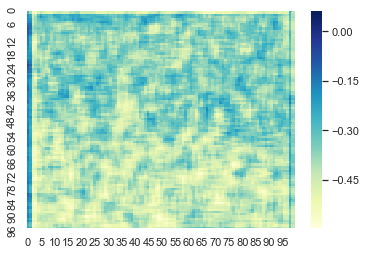

In [28]:
sns.set()
sns.heatmap(a.T,cmap="YlGnBu")

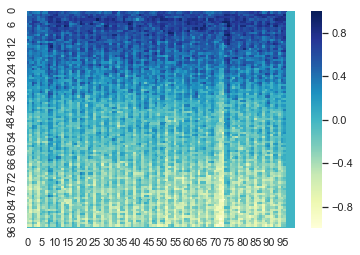

In [96]:
sns.heatmap(X_train[0].reshape(100,100).T,cmap="YlGnBu")

# AnoGAN

In [34]:
### anomaly loss function 
def load_weights(g_weight, d_weight):
    g.load_weights(g_weight)
    d.load_weights(d_weight)
    return g,d

def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

def anogan(Height, Width, channel=1):
    g.trainable = False
    input_ano = Input((100,))
    #in_h = int(Height / 4)
    #in_w = int(Width / 4)
    g_in = Dense(100, activation='tanh', trainable=True)(input_ano)
    g_out = g(g_in)
    model = Model(inputs=input_ano, outputs=g_out)
    return model

def compute_anomaly_score(model, x, iterations):
    z = np.random.uniform(-1, 1, size=(1, 100))
    # learning for changing latent
    loss = model.fit(z, x, batch_size=1, epochs=iterations, verbose=0)
    loss = loss.history['loss'][-1]
    similar_data = model.predict_on_batch(z)
    return loss, similar_data

In [48]:
g,d = load_weights('/Users/hiroki/github/shunt/weight/generator_weights0.hdf5','/Users/hiroki/github/shunt/weight/discreminator_weights0.hdf5')

a_gan = anogan(Height=100, Width=100, channel=1)
anogan_optim = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
a_gan.compile(loss=sum_of_residual, optimizer=anogan_optim)
K.set_learning_phase(0)

In [53]:
iterations = 200
X_test = spectrogram_4d[60:61]
#-------------------------------------------------------------
for i in X_test:  
    test_img = i.reshape(1,100,100)
    anomaly_score, generated_img = compute_anomaly_score(a_gan, test_img, iterations)
    print(anomaly_score)

374301.09375


In [54]:
anomaly_score

374301.09375

In [55]:
a = generated_img[0].reshape(100,100)

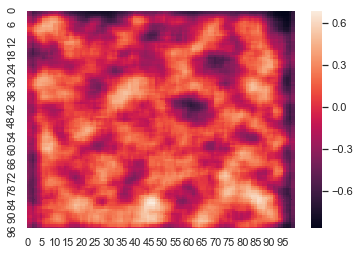

In [56]:
sns.heatmap(a.T)

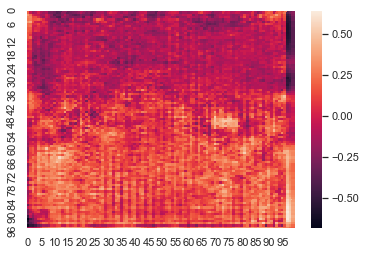

In [153]:
sns.heatmap(a.T)